In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

In [2]:
df = pd.read_csv('prepared_data.csv')
df['payment_date'] = pd.to_datetime(df['payment_date']).dt.date

In [3]:
gby = df.groupby('account_id')
gby.first('payment_date')

grouped = df.groupby('account_id').agg(
    {'payment_date': ['min', 'max'],
     'payment_amount': ['sum'],
      'gender': ['first'],
      'village': ['first'],
      'age_group': ['first'],
      'age': ['first']}).reset_index()

grouped.head()

account_id payment_date             payment_amount  gender    village  \
                      min         max            sum   first      first   
0          4   2016-09-25  2023-02-11       297854.5    male      Lichk   
1          8   2016-01-11  2023-02-11       313900.0    male    Yeranos   
2          9   2016-01-18  2023-03-09       374000.0  female      Lichk   
3         10   2016-02-12  2023-02-06       381850.0    male  Vardadzor   
4         12   2016-01-27  2023-02-01       479019.0  female   Vardenis   

  age_group   age  
      first first  
0     40-60    59  
1       60+    32  
2       60+    20  
3       60+    54  
4  Under 30    26

### The summarized data provides a comprehensive overview of individual payment histories, revealing trends in payment timings and amounts, along with key demographic details such as gender, village, age group, and age. This information is crucial for understanding payment behaviors and demographic patterns among account holders.

In [4]:
grouped.columns = ['account_id','first_purchase_date','last_purchase_date',"payment_amount",'gender','village','age_group','age']
grouped['survival_time_in_days'] = list(map(lambda x: x.days ,grouped['last_purchase_date']-grouped['first_purchase_date'] ))
grouped['avg_daily_payment_amount'] = grouped['payment_amount']/grouped['survival_time_in_days'] 

In [5]:
grouped = grouped.sort_values(by='avg_daily_payment_amount', ascending=True)
sorted = np.sort(grouped['avg_daily_payment_amount'])

In [6]:
bins = [-float('inf'), 133, 150, 200, float('inf')]
labels = ['Risky', 'Bronze', 'Silver', 'Gold']
grouped['payment_tier'] = pd.cut(grouped['avg_daily_payment_amount'], bins=bins, labels=labels)

In [7]:
grouped['duration']  = grouped['last_purchase_date']-grouped['first_purchase_date']
grouped['duration_in_days'] = list(map(lambda x: x.days ,grouped['duration'] ))

In [8]:
grouped['start'] = datetime.date(year = 2020, month=1,day = 1)
grouped['end'] = datetime.date(year = 2022, month=1,day = 1)
filter = grouped['last_purchase_date'] < grouped['start']
filter |= grouped['first_purchase_date'] > grouped['end']
grouped = grouped[~filter]

grouped['first_purchase_date'] = [ max(fpd,st) for fpd, st in zip(grouped['first_purchase_date'], grouped['start'])]
grouped['event'] = grouped['last_purchase_date'] < grouped['end']
grouped['last_purchase_date'] = [ min(fpd,st) for fpd, st in zip(grouped['last_purchase_date'], grouped['end'])]

grouped['duration']  = grouped['last_purchase_date']-grouped['first_purchase_date']
grouped['duration_in_days'] = list(map(lambda x: x.days ,grouped['duration'] ))

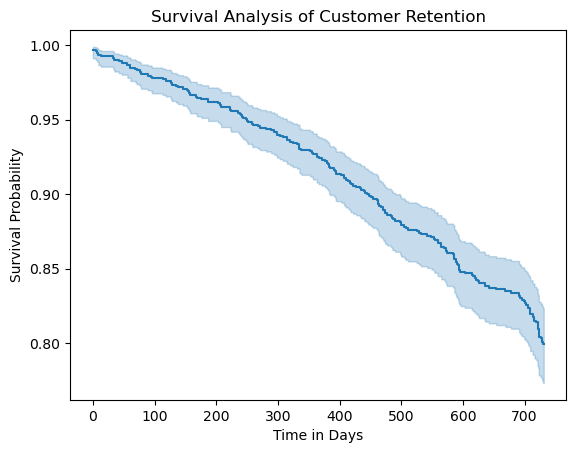

In [9]:
kmf = KaplanMeierFitter()
kmf.fit(grouped['duration_in_days'], event_observed=grouped['event'])
kmf.plot_survival_function()
plt.xlabel('Time in Days') 
plt.ylabel('Survival Probability') 
plt.title('Survival Analysis of Customer Retention')
plt.legend().remove()
plt.show()

### The Kaplan-Meier survival analysis, based on customers' history, effectively segments customer retention over time. The analysis window is set between 2020 and 2022 to observe active customer behavior, providing valuable insights for strategizing customer engagement and retention policies in a business setting. We can conclude that the 20% of the customers have churned during the period 2020 to 2022. The gradual decline in survival probability suggests that engagement drops as time progresses. To counteract this trend, businesses could implement loyalty programs, personalized marketing, and improved customer service.

### Now it is the time to conduct Log-Rank test to compare survival curves across different strata. By conducting the Log-Rank test for age groups, gender, regions, and customer groups segmented by their Recency, Frequency, and Monetary (RFM) scores, we can statistically ascertain if there are significant differences in retention rates. 

#### Let's start with comparing gender groups

Log-rank test p-value for gender pair ('male', 'female'): 0.3018534299138004


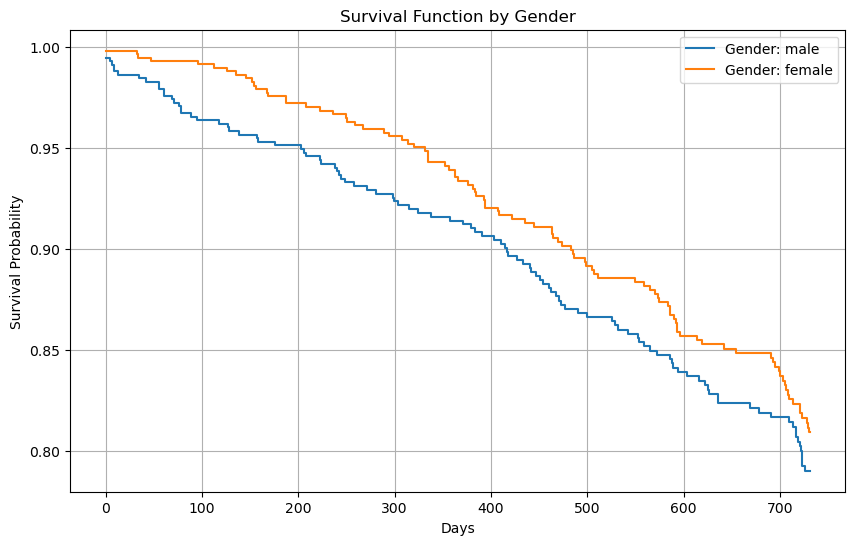

In [10]:
column = 'gender'

genders = grouped['gender'].unique()
survival_curves = {}

for gender in genders:
    group_data = grouped[grouped['gender'] == gender]
    kmf.fit(group_data['duration_in_days'], event_observed=group_data['event'], label=gender)
    survival_curves[gender] = kmf.survival_function_

plt.figure(figsize=(10, 6))
for gender, survival_function in survival_curves.items():
    plt.step(survival_function.index, survival_function[gender], where="post", label=f'Gender: {gender}')

plt.title('Survival Function by Gender')
plt.xlabel('Days')
plt.ylabel('Survival Probability')
plt.legend()
plt.grid(True)

if len(genders) > 1:
    gender_pairs = [(genders[i], genders[j]) for i in range(len(genders)) for j in range(i+1, len(genders))]
    logrank_results = {}

    for g1, g2 in gender_pairs:
        group1 = grouped[grouped['gender'] == g1]
        group2 = grouped[grouped['gender'] == g2]
        result = logrank_test(group1['duration_in_days'], group2['duration_in_days'],
                              event_observed_A=group1['event'], event_observed_B=group2['event'])
        logrank_results[(g1, g2)] = result.p_value

    for pair, p_value in logrank_results.items():
        print(f"Log-rank test p-value for gender pair {pair}: {p_value}")

plt.show()

### Conclusion: Visually we observe that there may be some difference between the survival curves of male and female customers. Noticably the orange curve(females) is in a higher position during the whole period from 2020 to 2022, which means that female customers tend to have a higher retention rate over time compared to males.However, towards the end of the period (around t = 700), this gap diminishes. This observation aligns with the Log-rank test's p-value for gender, which is 0.3018. Since this is above the 0.05 threshold, it indicates no statistically significant difference in retention between genders over the entire period analyzed.

#### Let's start with comparing age groups

Log-rank test p-value for age_group pair ('30-40', '40-60'): 0.26058735162413854
Log-rank test p-value for age_group pair ('30-40', '60+'): 0.10758035886722217
Log-rank test p-value for age_group pair ('30-40', 'Under 30'): 0.04007523854980345
Log-rank test p-value for age_group pair ('40-60', '60+'): 0.6605311607084766
Log-rank test p-value for age_group pair ('40-60', 'Under 30'): 0.37659073898818796
Log-rank test p-value for age_group pair ('60+', 'Under 30'): 0.6245270522035833


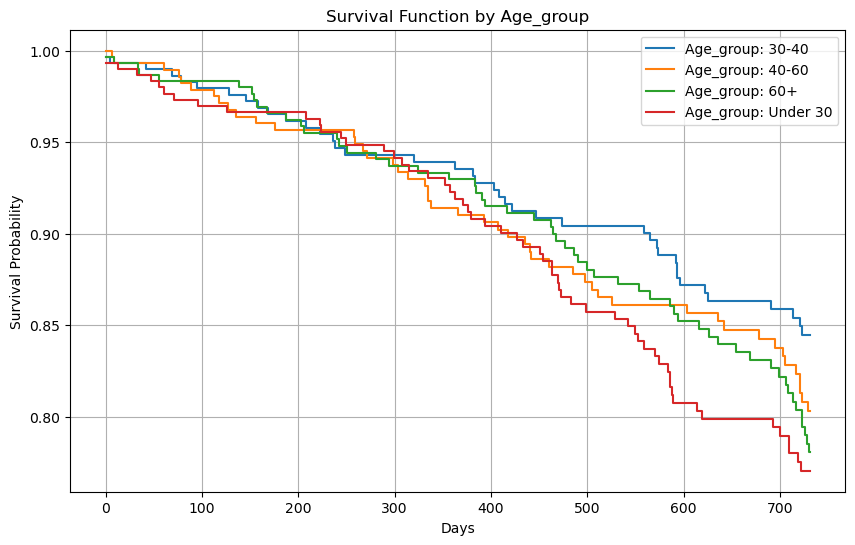

In [11]:
column_name = 'age_group' 
categories = grouped[column_name].unique()
survival_curves = {}

for category in categories:
    group_data = grouped[grouped[column_name] == category]
    kmf.fit(group_data['duration_in_days'], event_observed=group_data['event'], label=category)
    survival_curves[category] = kmf.survival_function_

plt.figure(figsize=(10, 6))
for category, survival_function in survival_curves.items():
    plt.step(survival_function.index, survival_function[category], where="post", label=f'{column_name.capitalize()}: {category}')

plt.title(f'Survival Function by {column_name.capitalize()}')
plt.xlabel('Days')
plt.ylabel('Survival Probability')
plt.legend()
plt.grid(True)

if len(categories) > 1:
    category_pairs = [(categories[i], categories[j]) for i in range(len(categories)) for j in range(i+1, len(categories))]
    logrank_results = {}

    for c1, c2 in category_pairs:
        group1 = grouped[grouped[column_name] == c1]
        group2 = grouped[grouped[column_name] == c2]
        result = logrank_test(group1['duration_in_days'], group2['duration_in_days'],
                              event_observed_A=group1['event'], event_observed_B=group2['event'])
        logrank_results[(c1, c2)] = result.p_value

    for pair, p_value in logrank_results.items():
        print(f"Log-rank test p-value for {column_name} pair {pair}: {p_value}")

plt.show()

### Conclusion: Upon examining the survival curves by age group, both visual inspection and Log-Rank test p-values indicate no significant difference in customer retention across the age categories. The survival curves overlap substantially throughout the observed period, and the p-values from the Log-Rank test confirm this lack of statistical significance, reinforcing the conclusion that age group does not play a discernible role in customer retention.

#### Let's start with comparing based on villages (region)

####  First, we'll examine a histogram showing the frequency of villages from 2020 to 2022. This will help us identify the three most prominent villages. We'll then conduct a Log-Rank test between these top villages to compare their customer retention rates over this period.

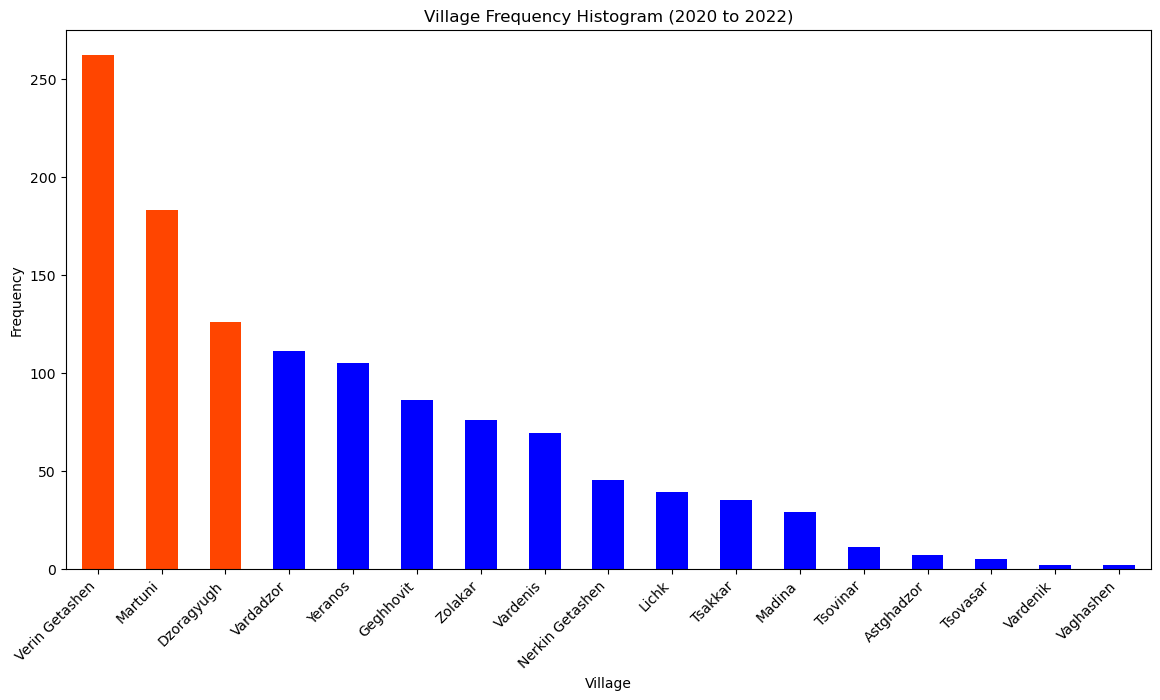

In [17]:
village_counts = grouped.groupby('village')['village'].count().sort_values(ascending=False)
colors = ['#FF4500' if i < 3 else 'blue' for i in range(len(village_counts))]

plt.figure(figsize=(14, 7))
village_counts.plot(kind='bar', color=colors)
plt.title('Village Frequency Histogram (2020 to 2022)')
plt.xlabel('Village')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha="right")
plt.show()

### Conclusion: We can clearly see that the top three regions are the Verin Getashen, Martuni and Dzoragyugh (in the period from 2020 to 2022), therefore we will do the Log-Rank test for the abovementioned three regions.

In [13]:
grouped['Region'] = grouped['village']
grouped.loc[~grouped['Region'].isin(['Martuni', 'Verin Getashen', 'Dzoragyugh']), 'Region'] = 'Other'
grouped_region = grouped[grouped['Region'] != 'Other']

Log-rank test p-value for Region pair ('Martuni', 'Dzoragyugh'): 0.07435537858945708
Log-rank test p-value for Region pair ('Martuni', 'Verin Getashen'): 0.5012192938676946
Log-rank test p-value for Region pair ('Dzoragyugh', 'Verin Getashen'): 0.19841367817916783


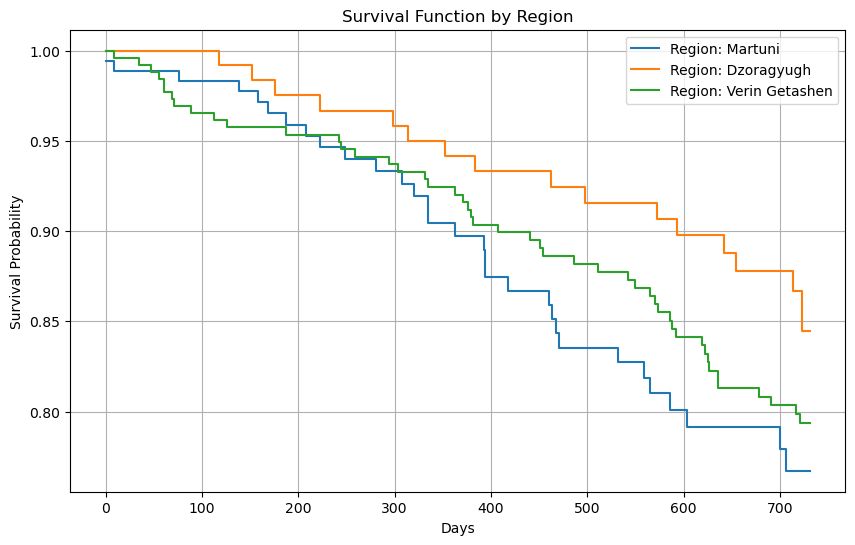

In [14]:
column_name = 'Region'
categories = grouped_region[column_name].unique()
survival_curves = {}

for category in categories:
    group_data = grouped_region[grouped_region[column_name] == category]
    kmf.fit(group_data['duration_in_days'], event_observed=group_data['event'], label=category)
    survival_curves[category] = kmf.survival_function_

plt.figure(figsize=(10, 6))
for category, survival_function in survival_curves.items():
    plt.step(survival_function.index, survival_function[category], where="post", label=f'{column_name.capitalize()}: {category}')

plt.title(f'Survival Function by {column_name.capitalize()}')
plt.xlabel('Days')
plt.ylabel('Survival Probability')
plt.legend()
plt.grid(True)

if len(categories) > 1:
    category_pairs = [(categories[i], categories[j]) for i in range(len(categories)) for j in range(i+1, len(categories))]
    logrank_results = {}

    for c1, c2 in category_pairs:
        group1 = grouped[grouped[column_name] == c1]
        group2 = grouped[grouped[column_name] == c2]
        result = logrank_test(group1['duration_in_days'], group2['duration_in_days'],
                              event_observed_A=group1['event'], event_observed_B=group2['event'])
        logrank_results[(c1, c2)] = result.p_value

    for pair, p_value in logrank_results.items():
        print(f"Log-rank test p-value for {column_name} pair {pair}: {p_value}")

plt.show()

### Conclusion: From the plot above we can claim that visually claim that the orange curve(Dzoragyugh) is in a higher position during the whole period from 2020 to 2022, which means that customers from Dzoragyugh tend to have a higher retention rate over time compared to customers from Martuni and Verin Getashen. After the 300th day the Vrein Getashen's curve is in consistently higher position than Martuni's curve, thus Martuni is the inferior position compared with the two regions. In the end Dzoragyugh's curve stops on survival probability equal to 0.84, but Verin Getashen's and Martuni's curves stop on 0.79 and 0.76 respectively.

In [15]:
customer_segment = pd.read_csv('customer_segment.csv')
grouped = pd.merge(grouped, customer_segment)

Log-rank test p-value for customer_segment pair ('Leaving Customers', 'Risky Customers'): 1.2006796846338227e-18
Log-rank test p-value for customer_segment pair ('Leaving Customers', 'Potential Loyalists'): 4.500858262397485e-84
Log-rank test p-value for customer_segment pair ('Leaving Customers', 'Champions'): 1.6252017944331323e-76
Log-rank test p-value for customer_segment pair ('Risky Customers', 'Potential Loyalists'): 1.130582376340553e-25
Log-rank test p-value for customer_segment pair ('Risky Customers', 'Champions'): 1.950641436000717e-28
Log-rank test p-value for customer_segment pair ('Potential Loyalists', 'Champions'): 0.0006987005142432818


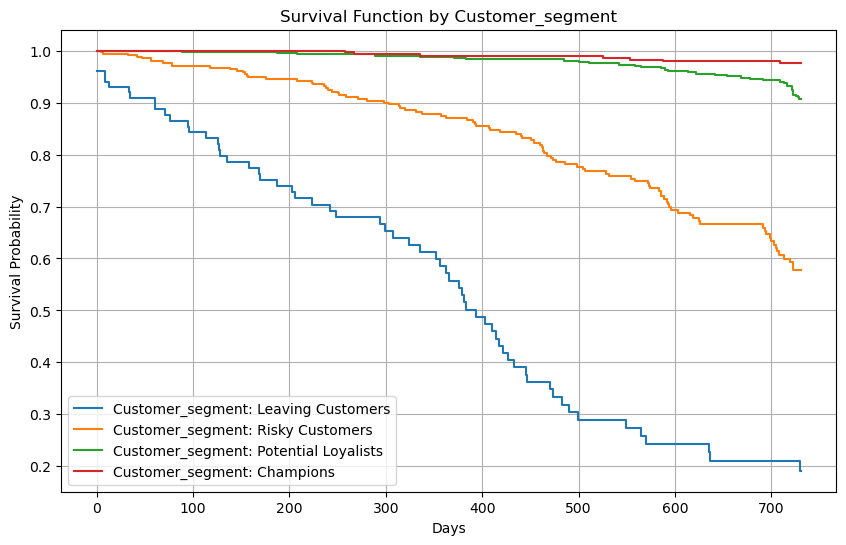

In [16]:
column_name = 'customer_segment'
categories = grouped[column_name].unique()
survival_curves = {}

for category in categories:
    group_data = grouped[grouped[column_name] == category]
    kmf.fit(group_data['duration_in_days'], event_observed=group_data['event'], label=category)
    survival_curves[category] = kmf.survival_function_

plt.figure(figsize=(10, 6))
for category, survival_function in survival_curves.items():
    plt.step(survival_function.index, survival_function[category], where="post", label=f'{column_name.capitalize()}: {category}')

plt.title(f'Survival Function by {column_name.capitalize()}')
plt.xlabel('Days')
plt.ylabel('Survival Probability')
plt.legend()
plt.grid(True)

if len(categories) > 1:
    category_pairs = [(categories[i], categories[j]) for i in range(len(categories)) for j in range(i+1, len(categories))]
    logrank_results = {}

    for c1, c2 in category_pairs:
        group1 = grouped[grouped[column_name] == c1]
        group2 = grouped[grouped[column_name] == c2]
        result = logrank_test(group1['duration_in_days'], group2['duration_in_days'],
                              event_observed_A=group1['event'], event_observed_B=group2['event'])
        logrank_results[(c1, c2)] = result.p_value

    for pair, p_value in logrank_results.items():
        print(f"Log-rank test p-value for {column_name} pair {pair}: {p_value}")

plt.show()

### Our analysis revealed distinct variations in churn rates among different customer segments from 2020 to 2022. The ‘Champions’ segment displayed the lowest churn rate, with only 3% leaving, followed by ‘Potential Loyalists’ at 10%, ‘Risky Customers’ at 42%, and ‘Leaving Customers’ with a high churn rate of nearly 80%. This pattern aligns with the expected behavior of these segments. The Log-Rank test results further substantiate these observations. The test showed highly significant differences between each pair of customer segments. The p-value for ‘Champions’ vs. ‘Potential Loyalists’ was 0.0007, indicating a notable difference in retention between these two segments. More strikingly, the comparison between ‘Champions’ and ‘Leaving Customers’ resulted in a p-value of approximately 1.63e-76, confirming a substantial disparity in retention rates. Similarly, ‘Potential Loyalists’ compared to ‘Leaving Customers’ yielded a p-value of around 4.50e-84. Even between ‘Risky Customers’ and ‘Leaving Customers,’ the difference was significant, with a p-value of 1.20e-18. These p-values, being well below the 0.05 threshold, clearly indicate significant differences in customer retention across these RFM segments.